# Regression to the mean and the decline of out-of-sample performance 
> In this short article, I will show why the out-of-sample performance of optimized models tends to decline, on average, which is a fundamental consequence of regression to the mean. This general shortfall of model optimization becomes more significant in environments of low signal to noise ratio, which is always the case in financial machine learning models.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Regression to the Mean, Model Optimization, Overfitting, Backtest Overfit]
- image: images/post_image_regression_to_the_mean.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

# Introduction

Essentially all trading strategies that we may develop, either constructed from fundamental (or not) principles or derived from machine learning models, end up having parameters that ultimately need to be somehow optimized and fixed. The commonplace observation is a performance decline when these models are brought to production (out-of-sample performance).

Besides the typical challenges that only emerge during live trading and that can hardly be estimated during backtesting, like price slippage, market impact, etc, there is a fundamental statistical reason behind the out-of-sample performance decline of optimized models: regression to the mean. In fact, parameter optimization in environments of low signal to noise ratio (SNR) is always accompanied by a certain amount of overfitting and selection bias.

In this short article, I will construct a simplified, yet generic numerical experiment demonstrating this effect. I will fix a random seed, in order to make the results completely reproducible:

In [1]:
random_seed = 42

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# The simulation model

Let's begin by setting up a prototype predictive model:

In [2]:
class PredictiveModel():
    
    def __init__(self, SNR):
        self.p_hit = 1.0/(np.exp(-SNR)+1)
        
    def set_seed(self, seed):
        self.seed = seed
        return self

    def get_model_returns(self, security_returns):
        rand = np.random.default_rng(self.seed)
        hit  = rand.choice(a     = [1,-1], 
                           size  = security_returns.shape[0],
                           p     = [self.p_hit, 1-self.p_hit])
        model_returns = np.abs(security_returns)*hit
        return model_returns
    
    def get_performance_statistics(self, security_returns):
        returns = self.get_model_returns(security_returns = security_returns)
        stats   = dict()
        stats.update({"Sharpe ratio": np.round((np.mean(returns)/np.std(returns))*np.sqrt(250), 3)})
        return stats

The model above is fully characterized by a given signal to noise ratio (SNR). Usually, SNR is a property of the data and not the model. Here, and without loss of generality, we can assume the data to noise-free and introduce noise into the model predictions instead. 

The SNR will determine the probability of the model correctly predicting the sign of the next-bar (day, for instance) price return, denoted $p_{\rm{hit}}$. We assume the relation

$$ p_{\rm{hit}} = \frac{1}{e^{-\rm{SNR}}+1}, $$ 

which is plotted below:

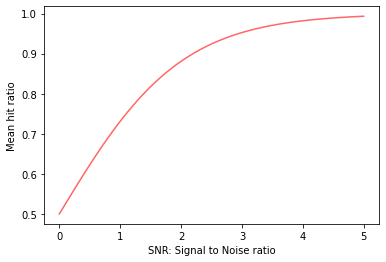

In [3]:
#collapse-show
def calculate_p_hit(SnR):
    return 1.0/(np.exp(-SnR)+1)

SNR_vals   = np.linspace(0, 5, 1000)
p_hit_vals = calculate_p_hit(SNR_vals)

fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(SNR_vals, p_hit_vals, color=(1.0,0.4,0.4))
axes.set_xlabel("SNR: Signal to Noise ratio")
axes.set_ylabel("Mean hit ratio")
plt.show()

A *PredictiveModel* object works by receiving an array of returns (simulating the returns of a security) into the *get_model_returns* method, which outputs a stochastic realization of model returns, associated with a given SNR. We can also call the method *get_performance_statistics* directly, which outputs the annualized Sharpe Ratio associated with the model returns. Note that the model is stochastic, in the sense that if we associate different random seeds (via the *set_seed* method), the model returns will be given by a different random realization, depending only on the probability of hit $p_{\rm{hit}}$ associated with the specified SNR.

Let's see an example:

We begin by sampling *n* random numbers from a normal distribution ($\mu=0$, $\sigma= \rm{volatility}$), representing the security returns

In [4]:
n          = 500
volatility = 0.05

rand = np.random.default_rng(random_seed)
r    = rand.normal(0, volatility, n)

We now instantiate a *PredictiveModel* object and simulate the performance of a strategy (model) given a specified SNR:

In [5]:
SNR  = 0.2

model = PredictiveModel(SNR = SNR).set_seed(seed = random_seed)

model_returns = model.get_model_returns(security_returns = r)
stats         = model.get_performance_statistics(security_returns=r)
stats

{'Sharpe ratio': 0.779}

We can also plot the simulated portfolio of this particular realization of the strategy, assuming a linear (arithmetic) combination of the model returns:

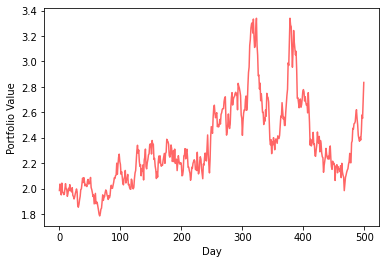

In [6]:
#collapse-hide
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(1+np.cumprod(1+model_returns), color=(1.0,0.4,0.4))
axes.set_xlabel("Day")
axes.set_ylabel("Portfolio Value")
plt.show()

# Regression to the mean: numerical example

Let's now build our numerical illustration of regression to the mean:

We consider an ensemble of *n_models* models. Each model is instantiated with an SNR drawn from an exponential distribution of mean *SNR_mean*. This means that within our ensemble, the models have a varying level of predictability. 

In order to handle the stochastic nature of the simulation, let's define two auxiliary objects that draw integer numbers from a uniform distribution (to be used as seeds):

In [7]:
class Sampler_Seed():
    def __init__(self, seed):
        self.rand = np.random.default_rng(seed)   
        
    def draw(self):
        return self.rand.integers(1, 1e10, size=1, dtype=int)[0]
    
sampler_seed = Sampler_Seed(seed=random_seed)

and samples from an exponential distribution (to be used as SNR):

In [8]:
class Sampler_SNR():
    def __init__(self, seed):
        self.rand = np.random.default_rng(seed)
        
    def draw(self, mean):
        return self.rand.exponential(scale=mean, size=1)[0]
    
sampler_SNR  = Sampler_SNR(seed=random_seed)            

Let's now instantiate the predictive models, each with a different random seed:

In [9]:
n_models = 100
SNR_mean = 0.05

In [10]:
models = [PredictiveModel(SNR=sampler_SNR.draw(mean=SNR_mean)).set_seed(seed=sampler_seed.draw()) 
          for i in range(n_models)]

Now we can generate a set of returns representing a given security, and split into training (in-sample) and testing (out-of-sample):

In [11]:
n_train    = 500
n_test     = 500
volatility = 0.05

In [12]:
r       = rand.normal(0, volatility, n_train+n_test)
r_train = r[0:n_train]
r_test  = r[n_train:(n_train+n_test)]

We now run all models in our in-sample optimization period and calculate the respective Sharpe ratio:

In [13]:
SR_train = [model.get_performance_statistics(security_returns=r_train)["Sharpe ratio"] for model in models]

The strategy can now be optimized by choosing the model whose respective Sharpe ratio is in a given quantile of the full distribution of Sharpe ratios (from all models). By setting this quantile to 1 we are choosing the model with the highest Sharpe ratio:

In [14]:
quantile = 1.0

In [15]:
optimal_model = models[np.argmin(np.abs(SR_train-np.quantile(SR_train, q=quantile)))]

Let's check the performance of the model:

In [16]:
model_returns_train = optimal_model.get_model_returns(security_returns=r_train)
optimal_model.get_performance_statistics(security_returns=r_train)

{'Sharpe ratio': 1.927}

Now that we have found the optimal model by maximing the Sharpe ratio, let's test the model performance in the out-of-sample portion of the data:

In [17]:
optimal_model.set_seed(seed=sampler_seed.draw())
model_returns_test = optimal_model.get_model_returns(security_returns=r_test)
optimal_model.get_performance_statistics(security_returns=r_test)

{'Sharpe ratio': 0.927}

We can also build both in-sample and out-of-sample portfolios:

In [18]:
portfolio_train = np.cumprod(1+model_returns_train)
portfolio_test  = np.cumprod(1+model_returns_test)

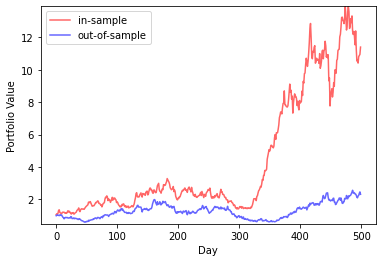

In [19]:
#collapse-hide
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(portfolio_train, color=(1.0,0.4,0.4), label="in-sample")
axes.plot(portfolio_test,  color=(0.4,0.4,1.0), label="out-of-sample")
axes.set_ylim([0.5, np.max(portfolio_train)])
axes.set_xlabel("Day")
axes.set_ylabel("Portfolio Value")
axes.legend()
plt.show()

Indeed the out-of-sample performance has greatly declined, despite all the data-generating processes being stationary. The reason behind this completely universal and ubiquitous effect lies in the fact that we are optimizing a model in the presence of noise. The optimal model has been selected partially due to its superior predictive power but also because of mere sample fluctuations of its set of predictions, due to the finite noise. In any optimization procedure, the presence of noise will always lead to some degree of overfitting, which is then responsible for the decline of out-of-sample performance. This effect becomes amplified in regimes of lower signal to noise ratio.

Let's conduct a more sophisticated version of the above Monte Carlo simulation, where the procedure above is repeated many times, so we can understand the effect beyond the result of a single realization. In fact, the out-of-sample performance decline is expected only on average.

# Full Monte Carlo simulation

In this section we are simply going to wrap the above procedure inside a *run_experiment* function, which will then be called for a large number of realizations:

In [20]:
def run_experiment(n_realizations, n_train, n_test, volatility, n_models, SNR_mean, quantile):
    
    # List to collect the  in-sample and out-of-sample Sharpe ratio of the optimized strategies
    in_SR  = list()
    out_SR = list()
    
    # Runs the full experiment
    for i in range(0, n_realizations):
        
        realization_seed = sampler_seed.draw()
        rand             = np.random.default_rng(realization_seed)
        
        # Draws the securities returns
        r = rand.normal(0, volatility, n_train+n_test)
        r_train = r[0:n_train]
        r_test  = r[n_train:(n_train+n_test)]
                        
        # Instantiates the different models
        models = [PredictiveModel(SNR=sampler_SNR.draw(mean=SNR_mean)).set_seed(seed=sampler_seed.draw()) 
                  for i in range(n_models)]        
        
        # Calculates the in-sample Sharpe ratio for each model
        SR = [model.get_performance_statistics(security_returns=r_train)["Sharpe ratio"] for model in models]
        
        # Finds the optimal model
        optimal_model = models[np.argmin(np.abs(SR-np.quantile(SR, q=quantile)))]

        # Retrieves the in-sample Sharpe ratio
        in_stats = optimal_model.get_performance_statistics(security_returns=r_train)
        in_SR.append(in_stats["Sharpe ratio"])        
        
        # Retrieves the out-of-sample Sharpe ratio
        out_stats = optimal_model.set_seed(seed=sampler_seed.draw()).get_performance_statistics(security_returns=r_test)
        out_SR.append(out_stats["Sharpe ratio"])
        
    return np.array(in_SR), np.array(out_SR)


Let's now set the parameters of the simulation, 

In [21]:
n_realizations = 100
n_train        = 500
n_test         = 500
volatility     = 0.05
n_models       = 100
quantile       = 1

and repeat the entire process for several values of the SNR mean:

In [22]:
SNR_mean_vals = np.linspace(0, 0.20, 50)

In [23]:
in_SRs  = list()
out_SRs = list()
for SNR_mean_val in tqdm(SNR_mean_vals):
    
    in_SR, out_SR = run_experiment(n_realizations = n_realizations,
                                   n_train        = n_train,
                                   n_test         = n_test,
                                   volatility     = volatility,
                                   n_models       = n_models,
                                   SNR_mean       = SNR_mean_val,
                                   quantile       = quantile)
    tmp_in        = np.zeros((in_SR.shape[0], 2))
    tmp_in[:,0]   = SNR_mean_val
    tmp_in[:,1]   = in_SR
    
    tmp_out       = np.zeros((out_SR.shape[0], 2))
    tmp_out[:,0]  = SNR_mean_val
    tmp_out[:,1]  = out_SR
    
    in_SRs.append(tmp_in)
    out_SRs.append(tmp_out)
    
in_SRs  = np.array(in_SRs)
out_SRs = np.array(out_SRs)

100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


Let's now plot the results:

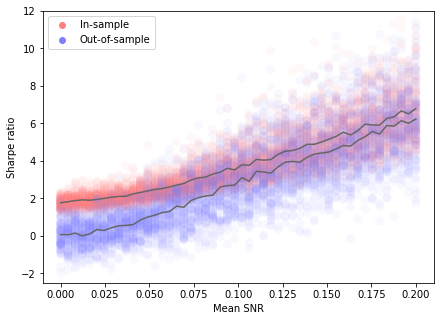

In [24]:
#collapse-hide
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

axes.scatter([], [], facecolor=(1.0,0.5,0.5), label="In-sample")
axes.scatter(x=in_SRs[:,:,0], s=80, y=in_SRs[:,:,1], facecolor=(1.0,0.5,0.5,0.05), edgecolors="none")
axes.scatter([], [], facecolor=(0.5,0.5,1.0), label="Out-of-sample")
axes.scatter(x=out_SRs[:,:,0], s=80, y=out_SRs[:,:,1], facecolor=(0.5,0.5,1.0,0.05), edgecolors="none")
axes.legend()
axes.plot(SNR_mean_vals, np.mean(in_SRs[:,:,1],1), color=(0.4,0.4,0.4))
axes.plot(SNR_mean_vals, np.mean(out_SRs[:,:,1],1), color=(0.4,0.4,0.4))
axes.set_xlabel("Mean SNR")
axes.set_ylabel("Sharpe ratio")
axes.set_ylim([-2.5, 12])
plt.show()

Let's now repeat the simulation but increasing the number of models in the optimization universe to 1000:

100%|██████████| 50/50 [14:20<00:00, 17.21s/it]


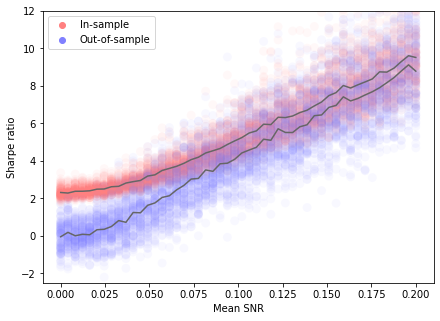

In [25]:
#collapse-hide
n_models = 1000

### Runs simulation
in_SRs  = list()
out_SRs = list()
for SNR_mean_val in tqdm(SNR_mean_vals):
    
    in_SR, out_SR = run_experiment(n_realizations = n_realizations,
                                   n_train        = n_train,
                                   n_test         = n_test,
                                   volatility     = volatility,
                                   n_models       = n_models,
                                   SNR_mean       = SNR_mean_val,
                                   quantile       = quantile)
    tmp_in        = np.zeros((in_SR.shape[0], 2))
    tmp_in[:,0]   = SNR_mean_val
    tmp_in[:,1]   = in_SR
    
    tmp_out       = np.zeros((out_SR.shape[0], 2))
    tmp_out[:,0]  = SNR_mean_val
    tmp_out[:,1]  = out_SR
    
    in_SRs.append(tmp_in)
    out_SRs.append(tmp_out)

in_SRs  = np.array(in_SRs)
out_SRs = np.array(out_SRs)

### Plotting

fig, axes = plt.subplots(1, 1, figsize=(7, 5))

axes.scatter([], [], facecolor=(1.0,0.5,0.5), label="In-sample")
axes.scatter(x=in_SRs[:,:,0], s=80, y=in_SRs[:,:,1], facecolor=(1.0,0.5,0.5,0.05), edgecolors="none")
axes.scatter([], [], facecolor=(0.5,0.5,1.0), label="Out-of-sample")
axes.scatter(x=out_SRs[:,:,0], s=80, y=out_SRs[:,:,1], facecolor=(0.5,0.5,1.0,0.05), edgecolors="none")
axes.legend()
axes.plot(SNR_mean_vals, np.mean(in_SRs[:,:,1],1), color=(0.4,0.4,0.4))
axes.plot(SNR_mean_vals, np.mean(out_SRs[:,:,1],1), color=(0.4,0.4,0.4))
axes.set_xlabel("Mean SNR")
axes.set_ylabel("Sharpe ratio")
axes.set_ylim([-2.5, 12])
plt.show()

The plots above clearly illustrate the point of this article. The out-of-sample performance decline becomes stronger is situations of low signal to noise ratio. It also illustrate the danger of conducting multiple testing and/or parameter optimization. Even fully random models will show an apparent good performance if enough trials are conducted. This selection bias is one of the most significant contributions to backtest overfit. 

An interesting idea that partially handles this limitation is the use of conveniently deflated Sharpe ratios, which examines the distribution of the maximum Sharpe ratio under multiple testing - {% cite Bailey2014 %} and  {% cite Prado2020%}.

It is worth noting that in the simulations conducted here, I have considered an ensemble of independent strategies (models). In reality, we often conduct multiple testing on a universe of highly correlated strategies. However, this distinction will only quantitatively affect the results, with the qualitative observations remaining unchanged.

{% bibliography --cited %}